#### IMPORTS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

### Functions

In [89]:
def plot_confustion_matrix(y_true, y_pred):
    c_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = [f'Count {value}' for value in c_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()


def test_model(x, y, model_type, **kwargs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
    model = model_type(**kwargs)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return {
        'model': model,
        'y_true': y_test,
        'y_pred': predictions,
        'x': x,
        'y': y
    }


def scale_data(df: pd.DataFrame, scaler=MinMaxScaler, **kwargs):
    df = df.copy()
    scaler = scaler(**kwargs)
    column_names = df.columns
    scaled_data = scaler.fit_transform(df)
    new_df = pd.DataFrame(scaled_data, columns=column_names)
    return new_df


list_to_str = lambda x: ", ".join([str(item) for item in x])
class_counts_to_list = lambda class_count: [f"{key}: {item}" for key, item in class_count.items()] 

#### Pre Processing

In [145]:
test_df = pd.read_csv('./data/class_test.csv')
train_df = pd.read_csv('./data/class_train.csv')
imbalanced_df = pd.concat([test_df, train_df])
imbalanced_class_count = imbalanced_df['Outcome'].value_counts()
print(f'Imbalanced dataset contains: {imbalanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(imbalanced_class_count))}]')

Imbalanced dataset contains: 116 rows with the class balances [1: 64, 0: 52]


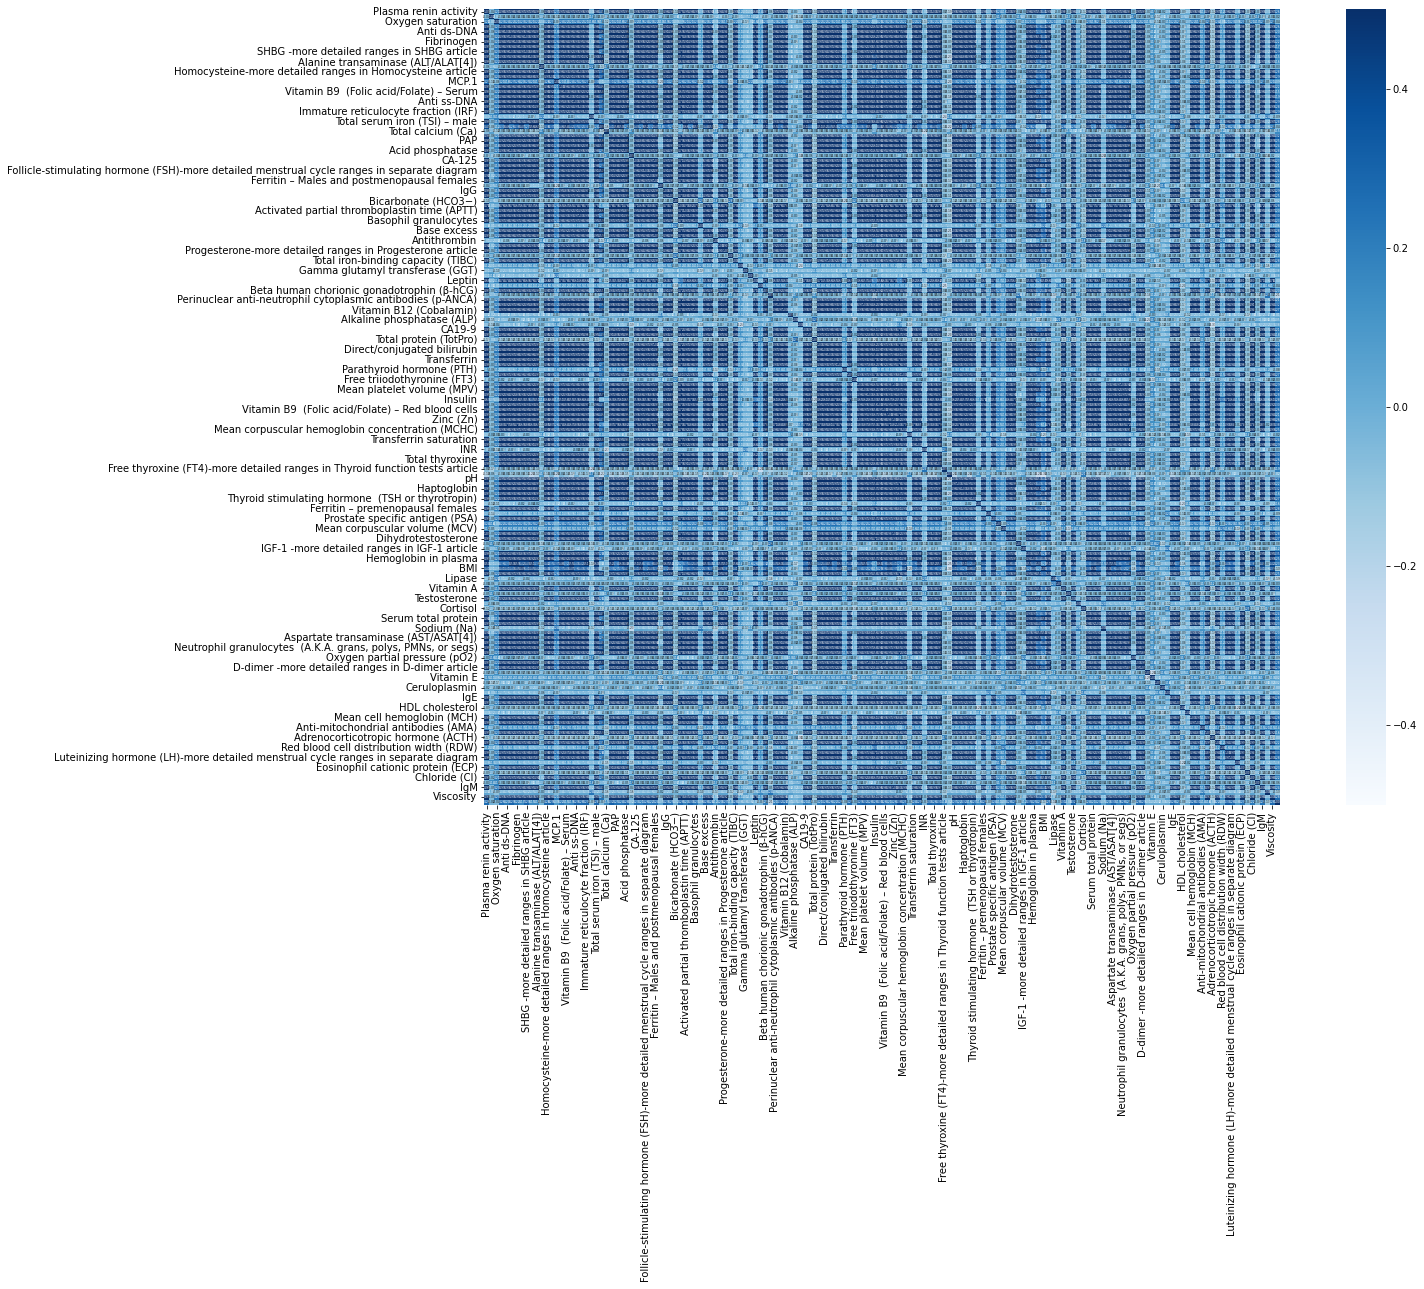

In [147]:
fig, ax = plt.subplots(figsize=(24, 18))
hm = sns.heatmap(imbalanced_df.corr(), cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

In [129]:
# Scaling Data
x = imbalanced_df.copy()   
y = x.pop('Outcome')
x_scaled = scale_data(x, scaler=MinMaxScaler)

### Balancing Data

In [130]:
smote = SMOTE(random_state=42)
x_balanced, y_balanced = smote.fit_resample(x_scaled, y)
balanced_df = pd.concat([x_balanced, y_balanced], axis=1)
balanced_class_count = balanced_df['Outcome'].value_counts()

print(f'Imbalanced dataset contains: {imbalanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(imbalanced_class_count))}]')
print(f'Balanced dataset contains: {balanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(balanced_class_count))}]')

Imbalanced dataset contains: 116 rows with the class balances [1: 64, 0: 52]
Balanced dataset contains: 128 rows with the class balances [0: 64, 1: 64]


Testing logistic reduction without pca.


0.7586206896551724


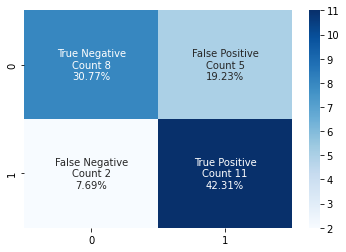

In [131]:
# Testing Logistic regression
result = test_model(x_balanced,y_balanced, LogisticRegression)
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)

0.6428571428571429


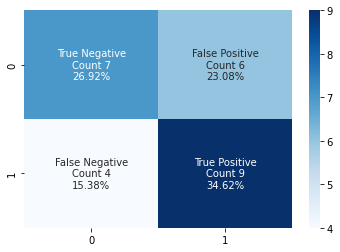

In [132]:
# Testing Support vector machine with kernel rbf
result = test_model(x_balanced, y_balanced, SVC, kernel='rbf')
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)

0.6666666666666667


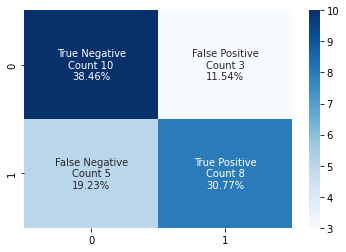

In [133]:
# Testing support vector machine with kernel linear
result = test_model(x_balanced, y_balanced, SVC, kernel='linear')
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)

### DIMENSION REDUCTION 

#### PCA

In [96]:
nr_of_components = int(min(x_balanced.shape[0], x_balanced.shape[1]))
pca = PCA(nr_of_components)
pca.fit(x_balanced)
ratios = np.cumsum(pca.explained_variance_ratio_)

# Finding kneepoint of convergence
kneedle = KneeLocator(range(len(ratios)), ratios, curve="concave", direction='increasing')
print(f'With {kneedle.knee} number of components we keep {ratios[kneedle.knee] * 100 }% of the information ')

With 40 number of components we keep 95.59330948832726% of the information 


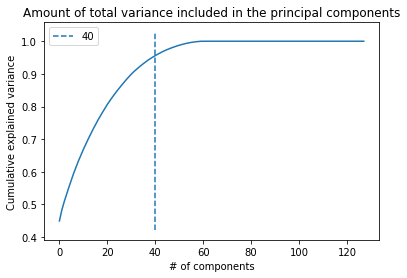

In [97]:
plt.plot(range(len(ratios)), ratios)
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label=kneedle.knee)
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.title("Amount of total variance included in the principal components")
plt.legend()
plt.show()

In [98]:
x_transformed = pca.transform(x_balanced)
x_transformed_and_reduced = x_transformed[:,:kneedle.knee]
print(f'With the kneepoint we can now filter down to {kneedle.knee} components')
print(f'Old shape: {x_transformed.shape}')
print(f'New shape: {x_transformed_and_reduced.shape}')

With the kneepoint we can now filter down to 40 components
Old shape: (128, 128)
New shape: (128, 40)


0.7142857142857142


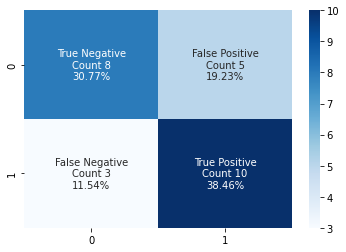

In [99]:
# Logistic Regression results with dimension reduction.
result = test_model(x_transformed_and_reduced, y_balanced, LogisticRegression)
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)


0.6428571428571429


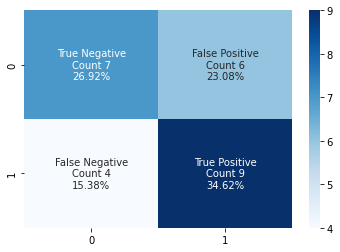

In [100]:
# SVM with rbf kernel results with dimension reduction.
result = test_model(x_transformed_and_reduced, y_balanced, SVC, kernel='rbf')
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)

0.7586206896551724


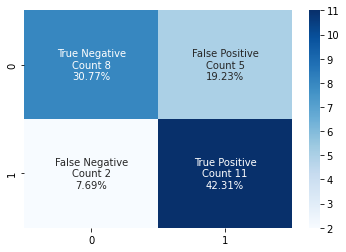

In [101]:
# SVM with linear kernel results with dimension reduction
result = test_model(x_transformed_and_reduced, y_balanced, SVC, kernel='linear')
y_true, y_pred = result['y_true'], result['y_pred']
scores = f1_score(y_true, y_pred)
print(scores)
plot_confustion_matrix(y_true, y_pred)

#### Feature selection with variance threshold

In [139]:
def feature_selection_with_variance_threshold(x: pd.DataFrame):
    x = x.copy()

    masks = []
    for variant in np.linspace(0.022, 0.075, num=10):
        selection = VarianceThreshold(threshold=variant)
        selection.fit_transform(x)
        masks.append(selection.get_support())
    
    return masks

masks = feature_selection_with_variance_threshold(x_balanced)
x_variants = [x_balanced.iloc[:, mask] for mask in masks]

In [141]:
lr_results = [test_model(x_variant, y_balanced, LogisticRegression) for x_variant in x_variants]
svm_rbf_results = [test_model(x_variant, y_balanced, SVC, kernel='rbf') for x_variant in x_variants]
svm_linear_results = [test_model(x_variant, y_balanced, SVC, kernel='linear') for x_variant in x_variants]

Best Logistic Regression f1 scores is: 0.7142857142857142
(128, 132)


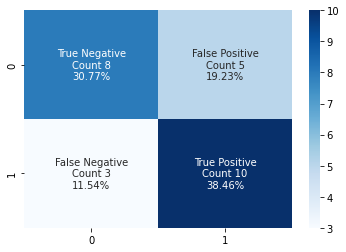

Best SVM rbf f1 scores is: 0.6428571428571429
(128, 132)


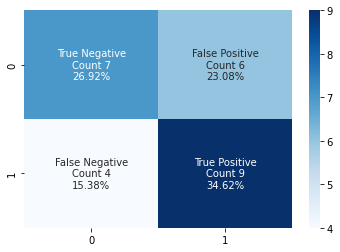

Best SVM linear f1 scores is: 0.6666666666666667
(128, 132)


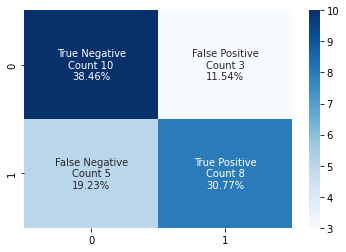

In [142]:
sorted_lr_results = sorted(lr_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)
sorted_svm_rbf_results = sorted(svm_rbf_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)
sorted_svm_linear_results = sorted(svm_linear_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)

best_lr_variant = sorted_lr_results[0]
best_svm_rbf_variant = sorted_svm_rbf_results[0]
best_svm_linear_variant = sorted_svm_linear_results[0]

print(f'Best Logistic Regression f1 scores is: {f1_score(best_lr_variant["y_true"], best_lr_variant["y_pred"])}')
print(best_lr_variant['x'].shape)
plot_confustion_matrix(best_lr_variant['y_true'], best_lr_variant['y_pred'])

print(f'Best SVM rbf f1 scores is: {f1_score(best_svm_rbf_variant["y_true"], best_svm_rbf_variant["y_pred"])}')
print(best_svm_rbf_variant['x'].shape)
plot_confustion_matrix(best_svm_rbf_variant['y_true'], best_svm_rbf_variant['y_pred'])

print(f'Best SVM linear f1 scores is: {f1_score(best_svm_linear_variant["y_true"], best_svm_linear_variant["y_pred"])}')
print(best_svm_linear_variant['x'].shape)
plot_confustion_matrix(best_svm_linear_variant['y_true'], best_svm_linear_variant['y_pred'])